In [1]:
from pyspark import SparkContext,SparkConf
from  pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation

In [2]:
spark

In [3]:
row_df = spark.read.format("csv").option("header","true").option("delimiter",",").option('inferschema','true').load("inputData/new_game_records.csv")

In [4]:
row_df.show(10)

+----------+-------+-------+-------+------------+-------+-------+-------+----+-----+
|hosteam_id|h_rates|hc_rate|h_stars|visitteam_id|v_rates|vc_rate|v_stars|gaps|label|
+----------+-------+-------+-------+------------+-------+-------+-------+----+-----+
|         2|   67.1|   55.7|      1|           1|   81.7|   78.6|      4|   0|    0|
|         2|   67.1|   55.7|      1|           1|   81.7|   78.6|      4|   0|    0|
|         3|   62.2|   54.3|      2|           1|   81.7|   78.6|      4|  -2|    0|
|         4|   64.6|   54.9|      1|           1|   81.7|   78.6|      4|   0|    0|
|         5|   50.0|   51.2|      0|           1|   81.7|   78.6|      4|   1|    0|
|         5|   50.0|   51.2|      0|           1|   81.7|   78.6|      4|   1|    0|
|         6|   34.1|   36.0|      0|           1|   81.7|   78.6|      4|   0|    0|
|         7|   57.3|   60.3|      1|           1|   81.7|   78.6|      4|   1|    0|
|         7|   57.3|   60.3|      1|           1|   81.7|   78.6|

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder

In [8]:
assemblers_input = row_df.columns[:-1]

In [14]:
train_df,test_df = row_df.randomSplit([0.7,0.3])
startTime = time()
assemblers_input = row_df.columns[:-1]
assembers = VectorAssembler(inputCols=assemblers_input,outputCol='features')
rf = RandomForestClassifier(labelCol='label',featuresCol='features')
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName="areaUnderROC")
rfvs = Pipeline(stages=[assembers,rf])
rfvs_model = rfvs.fit(train_df)
predict = rfvs_model.transform(test_df)
evaluator.evaluate(predict)

0.737792833473056

In [15]:
evaluator.evaluate(predict)

0.737792833473056

In [16]:
from time import time
def get_accuracy(parmmeter_name,parameter):
    startTime = time()
    assemblers_input = row_df.columns[:-1]
    assembers = VectorAssembler(inputCols=assemblers_input,outputCol='features')
    if(parmmeter_name=='impurity'):
        rf = RandomForestClassifier(labelCol='label',featuresCol='features',impurity=parameter)
    elif(parmmeter_name=='maxDepth'):
        rf = RandomForestClassifier(labelCol='label',featuresCol='features',maxDepth=parameter)
    else:
        rf = RandomForestClassifier(labelCol='label',featuresCol='features',maxBins=parameter)
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName="areaUnderROC")
    rfvs = Pipeline(stages=[assembers,rf])
    rfvs_model = rfvs.fit(train_df)
    durtion = time()- startTime
    predict = rfvs_model.transform(test_df)
    accuracy = evaluator.evaluate(predict)
    return [dution,accuracy,parameter]

In [67]:
import matplotlib.pyplot as plt
def showchart(df,evalparm,barData,lineData,yMIn,ymax):
    ax = df[barData].plot(kind='bar',title=evalparm,legend=True,fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData].values,marker='o',linewidth=2.0,color='r')
    plt.show()

In [11]:
datas1 = [test_model('impurity',i) for i in ['entropy','gini']]

In [62]:
import pandas as pd
df1 = pd.DataFrame(datas1,columns=['durtion','AUC','impurity'],index=['entroy','gini'])

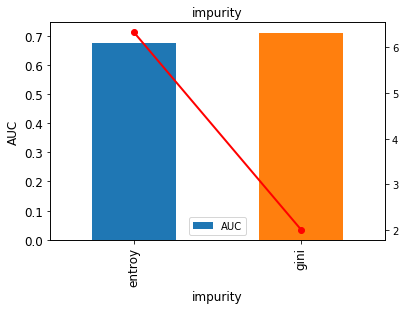

In [83]:
showchart(df,'impurity','AUC','durtion',0,1)

In [72]:
df2 = pd.DataFrame([test_model('maxBin',i) for i in [5,10,25,50,100]],columns=['durtion','AUC','maxBin'],index=[5,10,25,50,100])

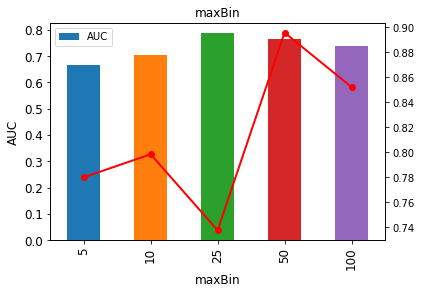

In [86]:
showchart(df2,'maxBin',"AUC",'durtion',0,1)

In [79]:
df3 = pd.DataFrame([test_model('maxDepth',i) for i in [3,5,15,20,25]],columns=['durtion','AUC','maxDepth'],index=[3,5,15,20,25])

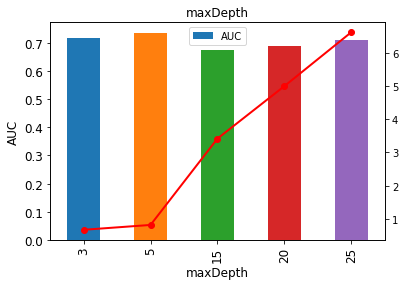

In [87]:
showchart(df3,'maxDepth','AUC','durtion',0,1)